## Feature Imputation using Machine Learning

In [276]:
# to prevent sklearn module not found error when import missforest
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [277]:
# set scikit learn to older version for missingpy import

In [278]:
#pip install scikit-learn==1.1.2

In [279]:
print(sklearn.__version__)

1.1.2


In [280]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from missingpy import MissForest
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from xgboost import cv
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from pprint import pprint

In [281]:
# setting display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## ML Feature Imputation

### Feature Encoding

In [282]:
# read in data
trainpath = "train.csv"
df_train = pd.read_csv(trainpath, index_col='ID')
testpath = "test.csv"
df_test = pd.read_csv(testpath, index_col='ID')

# concatenate dataframes to reduce redundancies in operations
df = pd.concat([df_train, df_test])

In [283]:
# Data Cleaning

#Functions
def replace_string(df, c, s, r='', f='strip'):
    if f == 'find_replace':
        mask = (df[c].notnull()) & (df[c].astype(str).str.contains(s))
        df.loc[mask, c] = df.loc[mask, c].astype(str).str.replace(s, r)
    if f == 'replace':
        df[c] = df[c].replace(s, r)
    elif f == 'strip':
        df[c] = df[c].dropna().astype(str).str.replace(s, r, regex=True)
    return df

def replace_numeric(df, c, n, r=0, f='match'):
    if f == 'isgreater':
        df.loc[df[c] > n, c] = r
    elif f == 'isless':
        df.loc[df[c] < n, c] = r
    elif f == 'match':
        df.loc[df[c] == n, c] = r
    return df

def convert_numeric(df, c, t, d=1):
    df[c] = pd.to_numeric(df[c], errors='coerce')
    df[c] = df[c].astype(t)
    df[c] = df[c] / d
    return df

In [284]:
df2 = df

# price
df2 = replace_string(df2, 'price', '$','', 'strip')
df2 = replace_string(df2, 'price', ',','', 'strip')
df2 = convert_numeric(df2, 'price', 'float', 1)

# host_response_rate
df2 = replace_string(df2, 'host_response_rate', '%','', 'strip')
df2 = convert_numeric(df2, 'host_response_rate', 'float', 100)

# host_acceptance_rate
df2 = replace_string(df2, 'host_acceptance_rate', '%','', 'strip')
df2 = convert_numeric(df2, 'host_acceptance_rate', 'float', 100)

# bathrooms
df2 = replace_string(df2, 'bathrooms', 'Half-bath','0.5', 'find_replace')
df2 = replace_string(df2, 'bathrooms', 'half-bath','0.5', 'find_replace')
df2 = replace_string(df2, 'bathrooms', '[^0-9\.]','', 'strip')
df2 = convert_numeric(df2, 'bathrooms', 'float', 1)

# max/min nights - replace extreme values
df2 = replace_numeric(df2, 'maximum_nights', 9000, 1000, 'isgreater')
df2 = replace_numeric(df2, 'minimum_maximum_nights', 9000, 1000, 'isgreater')
df2 = replace_numeric(df2, 'maximum_maximum_nights', 9000, 1000, 'isgreater')
df2 = replace_numeric(df2, 'minimum_nights_avg_ntm', 9000, 1000, 'isgreater')
df2 = replace_numeric(df2, 'maximum_nights_avg_ntm', 9000, 1000, 'isgreater')

In [285]:
df3 = df2

# Create new features email, phone and work_email from host_verifications
df3 = replace_string(df3, 'host_verifications', "['email']","'1','0','0'", 'replace')
df3 = replace_string(df3, 'host_verifications', "['phone']","'0','1','0'", 'replace')
df3 = replace_string(df3, 'host_verifications', "['email', 'phone']","'1','1','0'", 'replace')
df3 = replace_string(df3, 'host_verifications', "['phone', 'work_email']","'0','1','1'", 'replace')
df3 = replace_string(df3, 'host_verifications', "['email', 'phone', 'work_email']","'1','1','1'", 'replace')

df3[['email', 'phone', 'work_email']] = df3['host_verifications'].str.split(',', expand=True)

df3 = replace_string(df3, 'email', "'",'', 'strip')
df3 = convert_numeric(df3, 'email','int', 1)

df3 = replace_string(df3, 'phone', "'",'', 'strip')
df3 = convert_numeric(df3, 'phone','int', 1)

df3 = replace_string(df3, 'work_email', "'",'', 'strip')
df3 = convert_numeric(df3, 'work_email','int', 1)

df3.drop(['host_verifications'], axis=1, inplace=True)

In [286]:
# Create new features smoke_alarm, kitchen, essential, hangers, wifi from amenities
# These are the top 5 ammenities in the dataset

from collections import Counter

amenity_count = Counter()
amenity_count_total = Counter()
count_total = []

for amenities_str in df3['amenities']:
    amenity_count_total = 0
    amenities_list = amenities_str.strip('][').replace('"', '').split(', ')
    for amenity in amenities_list:
        amenity_count[amenity] += 1
        amenity_count_total  += 1
    count_total.append(amenity_count_total)

df_amenities = pd.DataFrame(columns=[ 'amenity_count'])
df_amenities['amenity_count'] = amenity_count
df_amenities = df_amenities.sort_values('amenity_count', ascending=False)
df_amenities.head(5)

#df_acc = pd.DataFrame(columns=[ 'total_amenity_counts'])
#df_acc['total_amenity_counts'] = count_total
#df_acc
#print(acc)

#Smoke alarm	9548
#Kitchen	9383
#Essentials	9327
#Hangers	8702
#Wifi	8618

df3['amenity_count'] = count_total

df3[['smoke_alarm','kitchen','essentials','hangers','wifi']] = 0

for idx, amenities_str in df3['amenities'].items():
    amenities_list = amenities_str.strip('][').replace('"', '').split(', ')
    if 'Smoke alarm' in amenities_list:
        df3.loc[idx, 'smoke_alarm'] = 1
    if 'Kitchen' in amenities_list:
        df3.loc[idx, 'kitchen'] = 1        
    if 'Essentials' in amenities_list:
        df3.loc[idx, 'essentials'] = 1      
    if 'Hangers' in amenities_list:
        df3.loc[idx, 'hangers'] = 1      
    if 'Wifi' in amenities_list:
        df3.loc[idx, 'wifi'] = 1              


df3.drop(['amenities'], axis=1, inplace=True)

In [287]:
df_amenities.iloc[0:50,]

,amenity_count
Smoke alarm,9548
Kitchen,9383
Essentials,9327
Hangers,8702
Wifi,8618
Iron,8359
Hair dryer,8328
Dishes and silverware,8111
Hot water,7986
Refrigerator,7479


#### Neighbourhood Groups based on mean neighbourhood price

In [288]:
df5 = df3

In [289]:
# Group neighbourhoods into low, medium, high based on average price
df5.groupby('neighbourhood_cleansed').price.mean().sort_values(ascending=False)

neighbourhood_cleansed
Boroondara           894.947712
Yarra                353.306695
Yarra Ranges         349.385484
Knox                 336.793651
Melbourne            335.346266
Bayside              325.077519
Kingston             265.690722
Port Phillip         263.867609
Cardinia             244.456790
Nillumbik            241.120000
Manningham           224.040000
Stonnington          214.961187
Moonee Valley        208.488636
Hobsons Bay          200.314286
Glen Eira            199.652778
Melton               198.325581
Frankston            198.207921
Hume                 194.348485
Wyndham              194.119760
Whitehorse           191.851852
Maroondah            183.270270
Whittlesea           179.805556
Brimbank             165.966667
Banyule              165.911392
Maribyrnong          163.893617
Monash               160.780347
Darebin              158.417219
Casey                150.600000
Moreland             144.171053
Greater Dandenong    115.406250
Name: price, dtyp

Mean price values per suburb are skewed due to outliers. Hence categorisation must be conducted based on data without outliers.

In [290]:
def get_outliers(data, threshold=3):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    z_scores = scaled_data.flatten()
    outlier_locations = np.where(np.abs(z_scores) > threshold)[0]
    outlier_values = data[outlier_locations]
    outlier_df = pd.DataFrame({'Outlier': outlier_values})
    return outlier_df

In [291]:
# Remove price outliers
price_outlier = get_outliers(df5['price'], threshold=3)
no_out = df5[~df5['price'].isin(price_outlier['Outlier'].values)]
no_out.reset_index(drop=True, inplace=True)

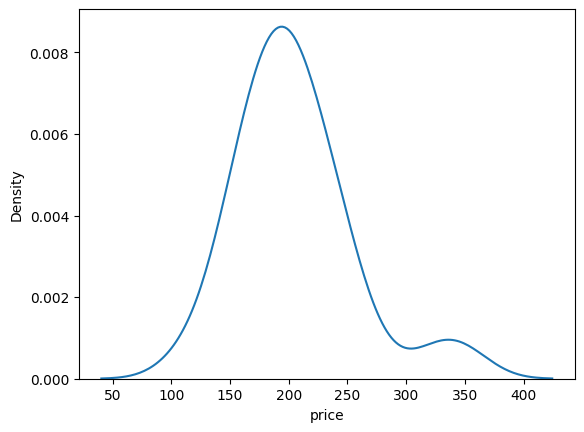

In [292]:
# check prices again
suburb_prices = no_out.groupby('neighbourhood_cleansed').price.mean().sort_values(ascending=False).reset_index()
sns.kdeplot(data=suburb_prices, x='price');

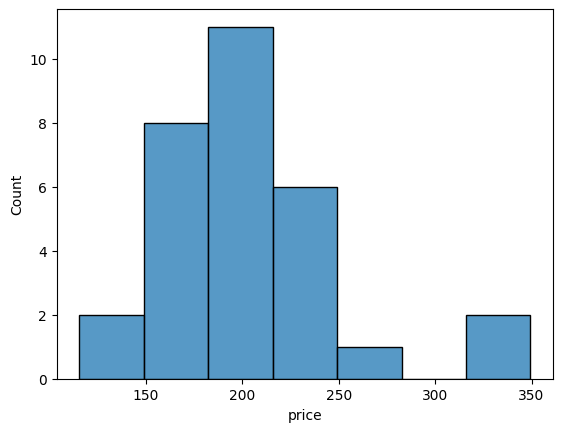

In [293]:
sns.histplot(data=suburb_prices, x='price');

It looks like the suburbs could be split into high and normal prices.

In [294]:
suburb_prices

,neighbourhood_cleansed,price
0,Yarra Ranges,349.385484
1,Bayside,325.077519
2,Kingston,265.690722
3,Cardinia,244.456790
4,Nillumbik,241.120000
5,Port Phillip,241.056628
6,Yarra,234.116883
7,Melbourne,228.756928
8,Manningham,224.040000
9,Stonnington,214.961187


In [295]:
# group suburbs based on quartiles

# Define the labels for the price groups
labels = ['low_price', 'medium_price', 'high_price']

# Categorize the suburbs based on mean prices
suburb_prices['suburb_prices'] = pd.qcut(suburb_prices.price, q=[0, 0.25, 0.75, 1], labels=labels)

suburb_prices

,neighbourhood_cleansed,price,suburb_prices
0,Yarra Ranges,349.385484,high_price
1,Bayside,325.077519,high_price
2,Kingston,265.690722,high_price
3,Cardinia,244.456790,high_price
4,Nillumbik,241.120000,high_price
5,Port Phillip,241.056628,high_price
6,Yarra,234.116883,high_price
7,Melbourne,228.756928,high_price
8,Manningham,224.040000,medium_price
9,Stonnington,214.961187,medium_price


In [296]:
# merge groups back into original df
df5 = df5.merge(suburb_prices[['neighbourhood_cleansed', 'suburb_prices']],on='neighbourhood_cleansed', how='left')

#### Convert Availability into high, medium, low

In [297]:
df5.availability_30.value_counts(dropna=False, normalize=True).reset_index().sort_values("index")

,index,availability_30
0,0,0.2379
2,1,0.0369
6,2,0.0344
12,3,0.0287
10,4,0.0331
7,5,0.0343
5,6,0.0345
4,7,0.0350
3,8,0.0359
1,9,0.0391


Rule set:
- < 5 days = high demand
- \>= 5 days & < 15 days = medium demand
- \>= 15 days = low demand

In [298]:
# Define the demand categories
demand_categories = ['high_demand', 'medium_demand', 'low_demand']

# Apply the logic using list comprehension
df5['demand_level'] = ['high_demand' if x < 5 else 'medium_demand' if x < 15 else 'low_demand' for x in df5.availability_30]

#### Label Encoding

In [300]:
#onehot encoder function
def onehot(df, c):
    for col in c:
        df = df.join(pd.get_dummies(df[[col]], drop_first=True))
        df.drop([col], axis=1, inplace=True)
    return df

#encode binary classifiers
# 'host_is_superhost','host_has_profile_pic','host_identity_verified','has_availability','instant_bookable'
df5 = onehot(df5, ['source', 'host_is_superhost','host_has_profile_pic','host_identity_verified','has_availability','instant_bookable', 'demand_level'])

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

#encode source
#le = encoder.fit_transform(df5['source'].values)
#df5['source'] = le
#print('source:', encoder.classes_)

#encode room_type alternative (1): ordinal --> more space/privacy = more value
# create dictionary to map values
room_mapping = {'Entire home/apt':4, 'Private room':3, 'Hotel room':2, 'Shared room':1}
df5['room_type'] = df5['room_type'].map(room_mapping) # use map function

# encode room type alternative (2): onehot --> evaluate if prevalence of room type equals a difference in price
#df5 = onehot(df5, ['room_type'])

#le = encoder.fit_transform(df5['room_type'].values)
#df5['room_type'] = le
#room_type_classes = encoder.classes_


#encode top 5 property_type and other
top_5_property_type = df5['property_type'].value_counts().nlargest(5).index.tolist()  
encoder.fit(top_5_property_type + ['other'])  
#df5['property_type_encoded'] = df5['property_type'].apply(lambda x: x if x in top_5_property_type else 'other')
df5['property_type'] = df5['property_type'].apply(lambda x: x if x in top_5_property_type else 'other')
df5 = onehot(df5, ['property_type'])


#encode top 5 neighbourhood_cleansed and other
top_5_neighbourhood_cleansed = df5['neighbourhood_cleansed'].value_counts().nlargest(5).index.tolist()  
encoder.fit(top_5_neighbourhood_cleansed + ['other'])  

df5['neighbourhood_cleansed'] = df5['neighbourhood_cleansed'].apply(lambda x: x if x in top_5_neighbourhood_cleansed else 'other')
df5 = onehot(df5, ['neighbourhood_cleansed'])

# encode neighbourhood price groups
df5 = onehot(df5, ['suburb_prices']) # alternatively ordinal

# map/rank host_response_time
host_response_mapping = {'within an hour':1, 'within a few hours':2, 'within a day':3, 'a few days or more':4}
df5['host_response_time'] = df5['host_response_time'].map(host_response_mapping)

# convert host_since into days based on current date
from datetime import datetime
today = datetime.today()
df5['host_since'] = pd.to_datetime(df5['host_since'], format='%Y/%m/%d')
df5['host_since'] = (today - df5['host_since']).dt.days

# convert first_review into days based on current date
df5['first_review'] = pd.to_datetime(df5['first_review'], format='%Y/%m/%d')
df5['first_review'] = (today - df5['first_review']).dt.days

# convert last_review into days based on current date
df5['last_review'] = pd.to_datetime(df5['last_review'], format='%Y/%m/%d')
df5['last_review'] = (today - df5['last_review']).dt.days

In [302]:
df5.columns

Index(['name', 'description', 'neighborhood_overview', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_neighbourhood',
       'host_listings_count', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host

In [303]:
df7 = df5
#df7.drop(['name', 'description','neighborhood_overview','host_name',
#          'host_about','neighbourhood','latitude','longitude'], axis=1, inplace=True)
df7.drop(['name', 'description','neighborhood_overview','host_name',
          'host_about','neighbourhood'], axis=1, inplace=True)

df7.drop(['host_location', #'host_response_rate','host_acceptance_rate',
          'host_neighbourhood',
          #'host_listings_count'
         ], 
          axis=1, inplace=True)
df7.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)
#df7.drop(['number_of_reviews','number_of_reviews_ltm', 'number_of_reviews_l30d'], axis=1, inplace=True)
df7.drop([#'first_review', 
    'last_review'], axis=1, inplace=True)
#df7.drop(['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'], axis=1, inplace=True) 
df7.drop(['calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)
#df7.drop(['reviews_per_month'], axis=1, inplace=True)
 
df7

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,price,email,phone,work_email,amenity_count,smoke_alarm,kitchen,essentials,hangers,wifi,source_previous scrape,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,has_availability_t,instant_bookable_t,demand_level_low_demand,demand_level_medium_demand,property_type_Entire home,property_type_Entire rental unit,property_type_Private room in home,property_type_Private room in rental unit,property_type_other,neighbourhood_cleansed_Port Phillip,neighbourhood_cleansed_Stonnington,neighbourhood_cleansed_Yarra,neighbourhood_cleansed_Yarra Ranges,neighbourhood_cleansed_other,suburb_prices_medium_price,suburb_prices_high_price
0,3725,1.0,1.00,0.98,2.0,-37.82030,144.99016,4.0,2,1.0,1.0,1.0,2,14,0,0,0,12.0,741,37,1,3712.0,4.88,4.91,4.97,4.94,4.93,4.93,4.82,6.11,132.0,1.0,1.0,0.0,38,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
1,5002,2.0,1.00,0.98,1.0,-37.76606,144.97951,3.0,2,1.0,1.0,1.0,4,27,0,12,22,112.0,169,25,3,3788.0,4.48,4.64,3.97,4.72,4.69,4.65,4.60,1.37,39.0,1.0,1.0,0.0,57,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,4199,2.0,1.00,0.78,2.0,-37.90546,145.39447,4.0,4,2.5,2.0,4.0,2,365,30,60,90,365.0,8,2,0,2883.0,4.75,4.88,4.75,4.88,4.50,5.00,4.75,0.09,270.0,1.0,1.0,0.0,21,1,1,0,0,1,0,1,1,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1
3,4732,3.0,0.75,0.92,4.0,-37.82163,144.96672,3.0,2,2.5,1.0,1.0,1,730,30,60,90,365.0,2,0,0,4242.0,4.50,4.00,4.50,4.00,4.00,5.00,4.00,0.01,1000.0,1.0,1.0,0.0,13,0,1,0,0,1,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
4,4703,2.0,1.00,0.87,1.0,-38.05725,145.33936,4.0,5,1.0,3.0,3.0,1,14,17,21,51,312.0,214,39,4,4568.0,4.86,4.91,4.98,4.91,4.93,4.90,4.87,1.43,116.0,1.0,1.0,1.0,49,1,1,1,1,1,0,1,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3219,NaN,NaN,NaN,1.0,-37.82025,145.03088,3.0,2,1.0,1.0,1.0,1,1125,0,0,0,0.0,2,0,0,2505.0,4.50,4.00,5.00,5.00,5.00,4.50,4.50,0.02,NaN,1.0,1.0,0.0,13,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
9996,1203,NaN,NaN,NaN,36.0,-37.83624,144.99299,4.0,2,1.0,1.0,1.0,1,90,1,1,1,268.0,42,9,0,1544.0,4.21,4.50,4.29,4.74,4.64,4.74,4.19,0.86,NaN,1.0,1.0,1.0,40,1,1,1,1,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0
9997,3125,1.0,1.00,0.92,36.0,-37.86326,144.75456,4.0,16,3.5,6.0,8.0,2,365,9,39,69,340.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,42,1,1,1,1,1,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0
9998,1765,NaN,NaN,NaN,2.0,-37.80913,144.96058,3.0,2,0.5,1.0,NaN,1,1125,0,0,0,0.0,3,0,0,1218.0,3.00,4.00,3.00,2.33,3.33,4.00,3.33,0.08,NaN,0.0,1.0,0.0,10,1,1,1,1,1,1,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [304]:
df_impute = df7.drop(['price', 'source_previous scrape'], axis=1)

In [305]:
df_impute.isnull().sum()

host_since                                     0
host_response_time                           737
host_response_rate                           737
host_acceptance_rate                         721
host_listings_count                            0
latitude                                       0
longitude                                      0
room_type                                    175
accommodates                                   0
bathrooms                                      6
bedrooms                                     438
beds                                          84
minimum_nights                                 0
maximum_nights                                 0
availability_30                                0
availability_60                                0
availability_90                                0
availability_365                              67
number_of_reviews                              0
number_of_reviews_ltm                          0
number_of_reviews_l3

### Miss Forest Classifier

In [306]:
%%capture --no-display
imputer = MissForest()
X_imputed = imputer.fit_transform(df_impute)

In [307]:
X_imputed = pd.DataFrame(X_imputed, columns = df_impute.columns)

In [308]:
X_imputed.isnull().sum()

host_since                                   0
host_response_time                           0
host_response_rate                           0
host_acceptance_rate                         0
host_listings_count                          0
latitude                                     0
longitude                                    0
room_type                                    0
accommodates                                 0
bathrooms                                    0
bedrooms                                     0
beds                                         0
minimum_nights                               0
maximum_nights                               0
availability_30                              0
availability_60                              0
availability_90                              0
availability_365                             0
number_of_reviews                            0
number_of_reviews_ltm                        0
number_of_reviews_l30d                       0
first_review 

In [309]:
X_imputed

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,email,phone,work_email,amenity_count,smoke_alarm,kitchen,essentials,hangers,wifi,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,has_availability_t,instant_bookable_t,demand_level_low_demand,demand_level_medium_demand,property_type_Entire home,property_type_Entire rental unit,property_type_Private room in home,property_type_Private room in rental unit,property_type_other,neighbourhood_cleansed_Port Phillip,neighbourhood_cleansed_Stonnington,neighbourhood_cleansed_Yarra,neighbourhood_cleansed_Yarra Ranges,neighbourhood_cleansed_other,suburb_prices_medium_price,suburb_prices_high_price
0,3725.0,1.00,1.0000,0.9800,2.0,-37.82030,144.99016,4.0,2.0,1.0,1.0,1.0,2.0,14.0,0.0,0.0,0.0,12.0,741.0,37.0,1.0,3712.00,4.880,4.9100,4.9700,4.9400,4.9300,4.9300,4.8200,6.11,1.0,1.0,0.0,38.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,5002.0,2.00,1.0000,0.9800,1.0,-37.76606,144.97951,3.0,2.0,1.0,1.0,1.0,4.0,27.0,0.0,12.0,22.0,112.0,169.0,25.0,3.0,3788.00,4.480,4.6400,3.9700,4.7200,4.6900,4.6500,4.6000,1.37,1.0,1.0,0.0,57.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4199.0,2.00,1.0000,0.7800,2.0,-37.90546,145.39447,4.0,4.0,2.5,2.0,4.0,2.0,365.0,30.0,60.0,90.0,365.0,8.0,2.0,0.0,2883.00,4.750,4.8800,4.7500,4.8800,4.5000,5.0000,4.7500,0.09,1.0,1.0,0.0,21.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4732.0,3.00,0.7500,0.9200,4.0,-37.82163,144.96672,3.0,2.0,2.5,1.0,1.0,1.0,730.0,30.0,60.0,90.0,365.0,2.0,0.0,0.0,4242.00,4.500,4.0000,4.5000,4.0000,4.0000,5.0000,4.0000,0.01,1.0,1.0,0.0,13.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4703.0,2.00,1.0000,0.8700,1.0,-38.05725,145.33936,4.0,5.0,1.0,3.0,3.0,1.0,14.0,17.0,21.0,51.0,312.0,214.0,39.0,4.0,4568.00,4.860,4.9100,4.9800,4.9100,4.9300,4.9000,4.8700,1.43,1.0,1.0,1.0,49.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3219.0,2.13,0.9750,0.2445,1.0,-37.82025,145.03088,3.0,2.0,1.0,1.0,1.0,1.0,1125.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2505.00,4.500,4.0000,5.0000,5.0000,5.0000,4.5000,4.5000,0.02,1.0,1.0,0.0,13.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9996,1203.0,1.00,0.9753,0.9846,36.0,-37.83624,144.99299,4.0,2.0,1.0,1.0,1.0,1.0,90.0,1.0,1.0,1.0,268.0,42.0,9.0,0.0,1544.00,4.210,4.5000,4.2900,4.7400,4.6400,4.7400,4.1900,0.86,1.0,1.0,1.0,40.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9997,3125.0,1.00,1.0000,0.9200,36.0,-37.86326,144.75456,4.0,16.0,3.5,6.0,8.0,2.0,365.0,9.0,39.0,69.0,340.0,0.0,0.0,0.0,1524.86,0.055,2.4718,2.5859,2.8947,2.6318,3.4425,2.4513,0.02,1.0,1.0,0.0,42.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9998,1765.0,2.11,0.9498,0.5479,2.0,-37.80913,144.96058,3.0,2.0,0.5,1.0,1.1,1.0,1125.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1218.00,3.000,4.0000,3.0000,2.3300,3.3300,4.0000,3.3300,0.08,0.0,1.0,0.0,10.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [310]:
# add price back
X_imputed['price'] = df7.price

# create logarithmic price column
X_imputed['log_price'] = np.log(X_imputed['price'])

X_imputed.to_csv("missforest_imputed.csv")

In [311]:
X_imputed

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,email,phone,work_email,amenity_count,smoke_alarm,kitchen,essentials,hangers,wifi,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,has_availability_t,instant_bookable_t,demand_level_low_demand,demand_level_medium_demand,property_type_Entire home,property_type_Entire rental unit,property_type_Private room in home,property_type_Private room in rental unit,property_type_other,neighbourhood_cleansed_Port Phillip,neighbourhood_cleansed_Stonnington,neighbourhood_cleansed_Yarra,neighbourhood_cleansed_Yarra Ranges,neighbourhood_cleansed_other,suburb_prices_medium_price,suburb_prices_high_price,price,log_price
0,3725.0,1.00,1.0000,0.9800,2.0,-37.82030,144.99016,4.0,2.0,1.0,1.0,1.0,2.0,14.0,0.0,0.0,0.0,12.0,741.0,37.0,1.0,3712.00,4.880,4.9100,4.9700,4.9400,4.9300,4.9300,4.8200,6.11,1.0,1.0,0.0,38.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,132.0,4.882802
1,5002.0,2.00,1.0000,0.9800,1.0,-37.76606,144.97951,3.0,2.0,1.0,1.0,1.0,4.0,27.0,0.0,12.0,22.0,112.0,169.0,25.0,3.0,3788.00,4.480,4.6400,3.9700,4.7200,4.6900,4.6500,4.6000,1.37,1.0,1.0,0.0,57.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39.0,3.663562
2,4199.0,2.00,1.0000,0.7800,2.0,-37.90546,145.39447,4.0,4.0,2.5,2.0,4.0,2.0,365.0,30.0,60.0,90.0,365.0,8.0,2.0,0.0,2883.00,4.750,4.8800,4.7500,4.8800,4.5000,5.0000,4.7500,0.09,1.0,1.0,0.0,21.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,270.0,5.598422
3,4732.0,3.00,0.7500,0.9200,4.0,-37.82163,144.96672,3.0,2.0,2.5,1.0,1.0,1.0,730.0,30.0,60.0,90.0,365.0,2.0,0.0,0.0,4242.00,4.500,4.0000,4.5000,4.0000,4.0000,5.0000,4.0000,0.01,1.0,1.0,0.0,13.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1000.0,6.907755
4,4703.0,2.00,1.0000,0.8700,1.0,-38.05725,145.33936,4.0,5.0,1.0,3.0,3.0,1.0,14.0,17.0,21.0,51.0,312.0,214.0,39.0,4.0,4568.00,4.860,4.9100,4.9800,4.9100,4.9300,4.9000,4.8700,1.43,1.0,1.0,1.0,49.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,116.0,4.753590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3219.0,2.13,0.9750,0.2445,1.0,-37.82025,145.03088,3.0,2.0,1.0,1.0,1.0,1.0,1125.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2505.00,4.500,4.0000,5.0000,5.0000,5.0000,4.5000,4.5000,0.02,1.0,1.0,0.0,13.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN
9996,1203.0,1.00,0.9753,0.9846,36.0,-37.83624,144.99299,4.0,2.0,1.0,1.0,1.0,1.0,90.0,1.0,1.0,1.0,268.0,42.0,9.0,0.0,1544.00,4.210,4.5000,4.2900,4.7400,4.6400,4.7400,4.1900,0.86,1.0,1.0,1.0,40.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN
9997,3125.0,1.00,1.0000,0.9200,36.0,-37.86326,144.75456,4.0,16.0,3.5,6.0,8.0,2.0,365.0,9.0,39.0,69.0,340.0,0.0,0.0,0.0,1524.86,0.055,2.4718,2.5859,2.8947,2.6318,3.4425,2.4513,0.02,1.0,1.0,0.0,42.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN
9998,1765.0,2.11,0.9498,0.5479,2.0,-37.80913,144.96058,3.0,2.0,0.5,1.0,1.1,1.0,1125.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1218.00,3.000,4.0000,3.0000,2.3300,3.3300,4.0000,3.3300,0.08,0.0,1.0,0.0,10.0,1.0,1.0,1.0,

## More Feature Engineering

In [312]:
df11 = X_imputed.copy()

In [313]:
df11

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,email,phone,work_email,amenity_count,smoke_alarm,kitchen,essentials,hangers,wifi,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,has_availability_t,instant_bookable_t,demand_level_low_demand,demand_level_medium_demand,property_type_Entire home,property_type_Entire rental unit,property_type_Private room in home,property_type_Private room in rental unit,property_type_other,neighbourhood_cleansed_Port Phillip,neighbourhood_cleansed_Stonnington,neighbourhood_cleansed_Yarra,neighbourhood_cleansed_Yarra Ranges,neighbourhood_cleansed_other,suburb_prices_medium_price,suburb_prices_high_price,price,log_price
0,3725.0,1.00,1.0000,0.9800,2.0,-37.82030,144.99016,4.0,2.0,1.0,1.0,1.0,2.0,14.0,0.0,0.0,0.0,12.0,741.0,37.0,1.0,3712.00,4.880,4.9100,4.9700,4.9400,4.9300,4.9300,4.8200,6.11,1.0,1.0,0.0,38.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,132.0,4.882802
1,5002.0,2.00,1.0000,0.9800,1.0,-37.76606,144.97951,3.0,2.0,1.0,1.0,1.0,4.0,27.0,0.0,12.0,22.0,112.0,169.0,25.0,3.0,3788.00,4.480,4.6400,3.9700,4.7200,4.6900,4.6500,4.6000,1.37,1.0,1.0,0.0,57.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39.0,3.663562
2,4199.0,2.00,1.0000,0.7800,2.0,-37.90546,145.39447,4.0,4.0,2.5,2.0,4.0,2.0,365.0,30.0,60.0,90.0,365.0,8.0,2.0,0.0,2883.00,4.750,4.8800,4.7500,4.8800,4.5000,5.0000,4.7500,0.09,1.0,1.0,0.0,21.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,270.0,5.598422
3,4732.0,3.00,0.7500,0.9200,4.0,-37.82163,144.96672,3.0,2.0,2.5,1.0,1.0,1.0,730.0,30.0,60.0,90.0,365.0,2.0,0.0,0.0,4242.00,4.500,4.0000,4.5000,4.0000,4.0000,5.0000,4.0000,0.01,1.0,1.0,0.0,13.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1000.0,6.907755
4,4703.0,2.00,1.0000,0.8700,1.0,-38.05725,145.33936,4.0,5.0,1.0,3.0,3.0,1.0,14.0,17.0,21.0,51.0,312.0,214.0,39.0,4.0,4568.00,4.860,4.9100,4.9800,4.9100,4.9300,4.9000,4.8700,1.43,1.0,1.0,1.0,49.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,116.0,4.753590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3219.0,2.13,0.9750,0.2445,1.0,-37.82025,145.03088,3.0,2.0,1.0,1.0,1.0,1.0,1125.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2505.00,4.500,4.0000,5.0000,5.0000,5.0000,4.5000,4.5000,0.02,1.0,1.0,0.0,13.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN
9996,1203.0,1.00,0.9753,0.9846,36.0,-37.83624,144.99299,4.0,2.0,1.0,1.0,1.0,1.0,90.0,1.0,1.0,1.0,268.0,42.0,9.0,0.0,1544.00,4.210,4.5000,4.2900,4.7400,4.6400,4.7400,4.1900,0.86,1.0,1.0,1.0,40.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN
9997,3125.0,1.00,1.0000,0.9200,36.0,-37.86326,144.75456,4.0,16.0,3.5,6.0,8.0,2.0,365.0,9.0,39.0,69.0,340.0,0.0,0.0,0.0,1524.86,0.055,2.4718,2.5859,2.8947,2.6318,3.4425,2.4513,0.02,1.0,1.0,0.0,42.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN
9998,1765.0,2.11,0.9498,0.5479,2.0,-37.80913,144.96058,3.0,2.0,0.5,1.0,1.1,1.0,1125.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1218.00,3.000,4.0000,3.0000,2.3300,3.3300,4.0000,3.3300,0.08,0.0,1.0,0.0,10.0,1.0,1.0,1.0,

### Variable Ratios

#### Re-weighting Review Scores
`review scores` should be higher weighted if these resulted from more reviews as this would be more accurate. We could first account for different timeframes by subtracting first_review from today_date and divide number_of_reviews by this difference to get the amount of reviews per day (could also do month by dividing by 30 to have smaller numbers) since the first review was made. This could then be multiplied by the review_scores to give them more weight if there were more number of reviews per day. Actually, there is the feature reviews_per_month which calculates the difference between first review and today. Hence we can use this to multiply. Doing so might have the following effects:
- we would penalise old listings that haven't been reviewed in a long time (there are some which had their last review in 2012, so their reviews might not be accurate anymore and should get less weight)

Based on feature importance from initial XGBoost models, we will scale `review_scores_location`, `review_scores_rating`, and `review_scores_value`.

In [314]:
columns = ['review_scores_rating', 'review_scores_location', 'review_scores_value']

for f in columns:
    if f in df11.columns:
        new_column = f + "_scaled"
        df11[new_column] = df11[f] * df11.reviews_per_month
        df11.drop(columns=[f], inplace=True)

df11.drop(columns=['reviews_per_month'], inplace=True)
df11

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,email,phone,work_email,amenity_count,smoke_alarm,kitchen,essentials,hangers,wifi,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,has_availability_t,instant_bookable_t,demand_level_low_demand,demand_level_medium_demand,property_type_Entire home,property_type_Entire rental unit,property_type_Private room in home,property_type_Private room in rental unit,property_type_other,neighbourhood_cleansed_Port Phillip,neighbourhood_cleansed_Stonnington,neighbourhood_cleansed_Yarra,neighbourhood_cleansed_Yarra Ranges,neighbourhood_cleansed_other,suburb_prices_medium_price,suburb_prices_high_price,price,log_price,review_scores_rating_scaled,review_scores_location_scaled,review_scores_value_scaled
0,3725.0,1.00,1.0000,0.9800,2.0,-37.82030,144.99016,4.0,2.0,1.0,1.0,1.0,2.0,14.0,0.0,0.0,0.0,12.0,741.0,37.0,1.0,3712.00,4.9100,4.9700,4.9400,4.9300,1.0,1.0,0.0,38.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,132.0,4.882802,29.8168,30.12230,29.450200
1,5002.0,2.00,1.0000,0.9800,1.0,-37.76606,144.97951,3.0,2.0,1.0,1.0,1.0,4.0,27.0,0.0,12.0,22.0,112.0,169.0,25.0,3.0,3788.00,4.6400,3.9700,4.7200,4.6900,1.0,1.0,0.0,57.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39.0,3.663562,6.1376,6.37050,6.302000
2,4199.0,2.00,1.0000,0.7800,2.0,-37.90546,145.39447,4.0,4.0,2.5,2.0,4.0,2.0,365.0,30.0,60.0,90.0,365.0,8.0,2.0,0.0,2883.00,4.8800,4.7500,4.8800,4.5000,1.0,1.0,0.0,21.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,270.0,5.598422,0.4275,0.45000,0.427500
3,4732.0,3.00,0.7500,0.9200,4.0,-37.82163,144.96672,3.0,2.0,2.5,1.0,1.0,1.0,730.0,30.0,60.0,90.0,365.0,2.0,0.0,0.0,4242.00,4.0000,4.5000,4.0000,4.0000,1.0,1.0,0.0,13.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1000.0,6.907755,0.0450,0.05000,0.040000
4,4703.0,2.00,1.0000,0.8700,1.0,-38.05725,145.33936,4.0,5.0,1.0,3.0,3.0,1.0,14.0,17.0,21.0,51.0,312.0,214.0,39.0,4.0,4568.00,4.9100,4.9800,4.9100,4.9300,1.0,1.0,1.0,49.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,116.0,4.753590,6.9498,7.00700,6.964100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3219.0,2.13,0.9750,0.2445,1.0,-37.82025,145.03088,3.0,2.0,1.0,1.0,1.0,1.0,1125.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2505.00,4.0000,5.0000,5.0000,5.0000,1.0,1.0,0.0,13.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0900,0.09000,0.090000
9996,1203.0,1.00,0.9753,0.9846,36.0,-37.83624,144.99299,4.0,2.0,1.0,1.0,1.0,1.0,90.0,1.0,1.0,1.0,268.0,42.0,9.0,0.0,1544.00,4.5000,4.2900,4.7400,4.6400,1.0,1.0,1.0,40.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,3.6206,4.07640,3.603400
9997,3125.0,1.00,1.0000,0.9200,36.0,-37.86326,144.75456,4.0,16.0,3.5,6.0,8.0,2.0,365.0,9.0,39.0,69.0,340.0,0.0,0.0,0.0,1524.86,2.4718,2.5859,2.8947,2.6318,1.0,1.0,0.0,42.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0011,0.06885,0.049026
9998,1765.0,2.11,0.9498,0.5479,2.0,-37.80913,144.96058,3.0,2.0,0.5,1.0,1.1,1.0,1125.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1218.00,4.0000,3.0000,2.3300,3.3300,0.0,1.0,0.0,10.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0

Allow us to capture information on multiple features as a ratio, thereby also reducing dimensionality of the data. We will create the following new features:\
- bathrooms/bedrooms: larger ratio would indicate more comfort --> should equal higher price
- bathrooms/accommodates: larger ratio would indicate more comfort --> should equal higher price
- bedrooms/accommodates : larger ratio would indicate more comfort --> should equal higher price
- beds/accommodates : larger ratio would indicate more comfort --> should equal higher price
- bedrooms/beds: larger ratio would indicate low comfort --> should equal lower price
- maximum_nights/minimum_nights not sure if relevant, but we could analyse. both of these variables were deemed relevant in my XGBoost model (this also is feature selection since we capture both variables at once).
- availability_365 /365: gives a ratio of how booked out the place is over the next year --> lower ratio would indicate high demand  --> should equal higher price
- room type / accommodates as proxy for space per person

#### Bathrooms / Bedrooms

In [315]:
df11['bath_bed_ratio'] = df11.bathrooms / df11.bedrooms

#### Bathrooms / Accommodates

In [316]:
df11['bath_guests_ratio'] = df11.bathrooms / df11.accommodates

#### Bedrooms / Accommodates

In [317]:
df11['bedrooms_guests_ratio'] = df11.bedrooms / df11.accommodates

#### Beds / Accommodates

In [318]:
df11['beds_guests_ratio'] = df11.beds / df11.accommodates

#### Bedrooms / Beds

In [319]:
df11['bedrooms_beds_ratio'] = df11.bedrooms / df11.beds

#### Maximum Nights / Minimum Nights

In [320]:
df11['maxnights_minnights_ratio'] = df11.maximum_nights / df11.minimum_nights

#### Room Type / Accommodates 

In [321]:
df11['roomtype_guests_ratio'] = df11.room_type / df11.accommodates

In [322]:
# show df again and save
df11
df11.to_csv("df11.csv")

### Test new Features Importances without dropping original Features and without outliers

In [323]:
df11 = pd.read_csv('df11.csv').drop(columns=['Unnamed: 0'])
df11.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,email,phone,work_email,amenity_count,smoke_alarm,kitchen,essentials,hangers,wifi,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,has_availability_t,instant_bookable_t,demand_level_low_demand,demand_level_medium_demand,property_type_Entire home,property_type_Entire rental unit,property_type_Private room in home,property_type_Private room in rental unit,property_type_other,neighbourhood_cleansed_Port Phillip,neighbourhood_cleansed_Stonnington,neighbourhood_cleansed_Yarra,neighbourhood_cleansed_Yarra Ranges,neighbourhood_cleansed_other,suburb_prices_medium_price,suburb_prices_high_price,price,log_price,review_scores_rating_scaled,review_scores_location_scaled,review_scores_value_scaled,bath_bed_ratio,bath_guests_ratio,bedrooms_guests_ratio,beds_guests_ratio,bedrooms_beds_ratio,maxnights_minnights_ratio,roomtype_guests_ratio
0,3725.0,1.0,1.00,0.98,2.0,-37.82030,144.99016,4.0,2.0,1.0,1.0,1.0,2.0,14.0,0.0,0.0,0.0,12.0,741.0,37.0,1.0,3712.0,4.91,4.97,4.94,4.93,1.0,1.0,0.0,38.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,132.0,4.882802,29.8168,30.1223,29.4502,1.000000,0.500,0.5,0.5,1.0,7.00,2.0
1,5002.0,2.0,1.00,0.98,1.0,-37.76606,144.97951,3.0,2.0,1.0,1.0,1.0,4.0,27.0,0.0,12.0,22.0,112.0,169.0,25.0,3.0,3788.0,4.64,3.97,4.72,4.69,1.0,1.0,0.0,57.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39.0,3.663562,6.1376,6.3705,6.3020,1.000000,0.500,0.5,0.5,1.0,6.75,1.5
2,4199.0,2.0,1.00,0.78,2.0,-37.90546,145.39447,4.0,4.0,2.5,2.0,4.0,2.0,365.0,30.0,60.0,90.0,365.0,8.0,2.0,0.0,2883.0,4.88,4.75,4.88,4.50,1.0,1.0,0.0,21.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,270.0,5.598422,0.4275,0.4500,0.4275,1.250000,0.625,0.5,1.0,0.5,182.50,1.0
3,4732.0,3.0,0.75,0.92,4.0,-37.82163,144.96672,3.0,2.0,2.5,1.0,1.0,1.0,730.0,30.0,60.0,90.0,365.0,2.0,0.0,0.0,4242.0,4.00,4.50,4.00,4.00,1.0,1.0,0.0,13.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1000.0,6.907755,0.0450,0.0500,0.0400,2.500000,1.250,0.5,0.5,1.0,730.00,1.5
4,4703.0,2.0,1.00,0.87,1.0,-38.05725,145.33936,4.0,5.0,1.0,3.0,3.0,1.0,14.0,17.0,21.0,51.0,312.0,214.0,39.0,4.0,4568.0,4.91,4.98,4.91,4.93,1.0,1.0,1.0,49.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,116.0,4.753590,6.9498,7.0070,6.9641,0.333333,0.200,0.6,0.6,1.0,14.00,0.8


In [324]:
test_ids = df11.index[7000:].values # save IDs for later output
X_train = df11.iloc[:7000]
X_test = df11.iloc[7000:]

In [325]:
# Standardize continuous columns
# Initialize a StandardScaler object for feature standardization
scaler = StandardScaler()

X_train_std = X_train.drop(['log_price', 'price'], axis=1).copy()
X_test_std = X_test.drop(['log_price', 'price'], axis=1).copy()

# Iterate through columns
for column in X_train_std.columns:
    # Check if the column has more than 10 unique values (threshold for categorical variables)
    if X_train_std[column].nunique() > 10:
        # Fit the StandardScaler on the training data
        scaler.fit(X_train_std[column].values.reshape(-1, 1))
        # Apply feature standardization to both training and test data
        X_train_std[column] = scaler.transform(X_train_std[column].values.reshape(-1, 1))
        X_test_std[column] = scaler.transform(X_test_std[column].values.reshape(-1, 1))
        
# put prices back
X_train_std[['log_price', 'price']] = X_train[['log_price', 'price']]
X_test_std[['log_price', 'price']] = X_test[['log_price', 'price']]

In [326]:
def get_outliers(data, threshold=3):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    z_scores = scaled_data.flatten()
    outlier_locations = np.where(np.abs(z_scores) > threshold)[0]
    outlier_values = data[outlier_locations]
    outlier_df = pd.DataFrame({'Outlier': outlier_values})
    return outlier_df

In [327]:
# Remove price outliers
price_outlier = get_outliers(X_train_std['price'], threshold=2)
X_train_std = X_train_std[~X_train_std['price'].isin(price_outlier['Outlier'].values)]
X_train_std.reset_index(drop=True, inplace=True)

In [328]:
y_train = X_train_std['log_price'].iloc[:7000].values
X_train_std = X_train_std.drop(['log_price', 'price'], axis=1)
X_test_std = X_test_std.drop(['log_price', 'price'], axis=1)

In [329]:
model = XGBRegressor()

feature_names = X_train_std.columns

model.fit(X_train_std, y_train)

importance = model.feature_importances_

df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importance })

df_importances['Rank'] = df_importances['Importance'].rank(ascending=False)

# Sort the importances by rank
df_importances = df_importances.sort_values(by='Rank')

# Print the feature importances with ranks
print(len(importance))
print(len(feature_names))
df_importances

64
64


,Feature,Importance,Rank
10,bedrooms,0.244029,1.0
8,accommodates,0.188173,2.0
7,room_type,0.118455,3.0
44,property_type_Private room in home,0.070877,4.0
53,suburb_prices_high_price,0.066169,5.0
9,bathrooms,0.037080,6.0
51,neighbourhood_cleansed_other,0.027938,7.0
63,roomtype_guests_ratio,0.017856,8.0
39,instant_bookable_t,0.016317,9.0
14,availability_30,0.012580,10.0


#### XGBoost

In [330]:
# xgboost on all predictors
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train_std, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(xgb, X_train_std, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

xgb.fit(X_train_std, y_train)


y_pred = xgb.predict(X_test_std)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("XGBRegressorPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.341834305459873


,ID,price
0,7000,172.610519
1,7001,142.044785
2,7002,173.855850
3,7003,195.351364
4,7004,207.745087
...,...,...
2995,9995,81.127220
2996,9996,194.104538
2997,9997,532.439697
2998,9998,132.100128


In [331]:
# top 30 features
df_importances_top30 = [x for x in df_importances.Feature][:30]

X_train_std_top30 = X_train_std.copy()
X_test_std_top30 = X_test_std.copy()

for f in X_train_std_top30.columns:
    if f not in df_importances_top30:
        X_train_std_top30.drop(columns=f, inplace=True)
        X_test_std_top30.drop(columns=f, inplace=True)
        
# xgboost on top 30 predictors
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train_std_top30, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(xgb, X_train_std_top30, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

xgb.fit(X_train_std_top30, y_train)

ypred_train = xgb.predict(X_train_std_top30)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = xgb.predict(X_test_std_top30)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("XGBRegressorPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.34994073504760864
Root Mean Squared Error: 56.007111489666556


,ID,price
0,7000,152.0
1,7001,157.0
2,7002,144.0
3,7003,180.0
4,7004,196.0
...,...,...
2995,9995,96.0
2996,9996,160.0
2997,9997,576.0
2998,9998,67.0


In [332]:
# top 15 features
df_importances_top15 = [x for x in df_importances.Feature][:15]

X_train_std_top15 = X_train_std.copy()
X_test_std_top15 = X_test_std.copy()

for f in X_train_std_top15.columns:
    if f not in df_importances_top15:
        X_train_std_top15.drop(columns=f, inplace=True)
        X_test_std_top15.drop(columns=f, inplace=True)
        
# xgboost on top 15 predictors
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train_std_top15, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(xgb, X_train_std_top15, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

xgb.fit(X_train_std_top15, y_train)

ypred_train = xgb.predict(X_train_std_top15)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = xgb.predict(X_train_std_top15)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

y_pred = xgb.predict(X_test_std_top15)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("XGBRegressorPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.3974598049647433
Root Mean Squared Error: 87.54275859781899


,ID,price
0,7000,179.452393
1,7001,162.556686
2,7002,78.619537
3,7003,262.472931
4,7004,174.211685
...,...,...
2995,9995,77.778320
2996,9996,107.026108
2997,9997,451.492096
2998,9998,69.489601


In [333]:
# top 10 features
df_importances_top10 = [x for x in df_importances.Feature][:10]

X_train_std_top10 = X_train_std.copy()
X_test_std_top10 = X_test_std.copy()

for f in X_train_std_top10.columns:
    if f not in df_importances_top10:
        X_train_std_top10.drop(columns=f, inplace=True)
        X_test_std_top10.drop(columns=f, inplace=True)
        
# xgboost on top 10 predictors
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train_std_top10, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(xgb, X_train_std_top10, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

xgb.fit(X_train_std_top10, y_train)

ypred_train = xgb.predict(X_train_std_top10)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = xgb.predict(X_train_std_top10)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

y_pred = xgb.predict(X_test_std_top10)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("XGBRegressorPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.40275273587305904
Root Mean Squared Error: 105.21544576337439


,ID,price
0,7000,231.887833
1,7001,176.989304
2,7002,52.142544
3,7003,188.039200
4,7004,148.751755
...,...,...
2995,9995,69.216438
2996,9996,121.017616
2997,9997,491.311920
2998,9998,71.680939


#### RandomForest

In [334]:
# on all predictors
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train_std, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(rfr, X_train_std, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

rfr.fit(X_train_std, y_train)


y_pred = rfr.predict(X_test_std)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("RandomForestPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.3538323658144686


,ID,price
0,7000,191.356823
1,7001,166.299793
2,7002,133.648110
3,7003,186.425358
4,7004,162.379445
...,...,...
2995,9995,82.679208
2996,9996,142.894011
2997,9997,524.252033
2998,9998,125.099057


In [335]:
# on top 30 predictors
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train_std_top30, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(rfr, X_train_std_top30, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

rfr.fit(X_train_std_top30, y_train)

ypred_train = rfr.predict(X_train_std_top30)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = rfr.predict(X_test_std_top30)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("RandomForestPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.35432594292905906
Root Mean Squared Error: 68.70413258122638


,ID,price
0,7000,201.0
1,7001,158.0
2,7002,114.0
3,7003,195.0
4,7004,185.0
...,...,...
2995,9995,79.0
2996,9996,137.0
2997,9997,481.0
2998,9998,79.0


In [336]:
# on top 15 predictors
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train_std_top15, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(rfr, X_train_std_top15, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

rfr.fit(X_train_std_top15, y_train)

ypred_train = rfr.predict(X_train_std_top15)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = rfr.predict(X_train_std_top15)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

y_pred = rfr.predict(X_test_std_top15)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("RandomForestPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.39805365471259824
Root Mean Squared Error: 78.17206899442094


,ID,price
0,7000,190.461721
1,7001,162.451558
2,7002,74.517724
3,7003,275.027943
4,7004,129.979237
...,...,...
2995,9995,98.091611
2996,9996,130.830689
2997,9997,429.907463
2998,9998,74.384690


In [337]:
# on top 10 predictors
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train_std_top10, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(rfr, X_train_std_top10, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

rfr.fit(X_train_std_top10, y_train)

ypred_train = rfr.predict(X_train_std_top10)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = rfr.predict(X_train_std_top10)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

y_pred = rfr.predict(X_test_std_top10)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("RandomForestPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.41522805083879505
Root Mean Squared Error: 100.72687322861515


,ID,price
0,7000,286.543870
1,7001,164.818579
2,7002,70.501512
3,7003,239.537660
4,7004,160.017005
...,...,...
2995,9995,70.275247
2996,9996,107.959671
2997,9997,409.354663
2998,9998,69.096406


### Test new Features Importances with dropping original Features and without outliers

In [338]:
test_ids = df11.index[7000:].values # save IDs for later output
X_train = df11.drop(columns=['accommodates', 'maximum_nights', 'minimum_nights', 'beds', 'number_of_reviews']).iloc[:7000]
X_test = df11.drop(columns=['accommodates', 'maximum_nights', 'minimum_nights', 'beds', 'number_of_reviews']).iloc[7000:]

In [339]:
# Standardize continuous columns
# Initialize a StandardScaler object for feature standardization
scaler = StandardScaler()

X_train_std = X_train.drop(['log_price', 'price'], axis=1).copy()
X_test_std = X_test.drop(['log_price', 'price'], axis=1).copy()

# Iterate through columns
for column in X_train_std.columns:
    # Check if the column has more than 10 unique values (threshold for categorical variables)
    if X_train_std[column].nunique() > 10:
        # Fit the StandardScaler on the training data
        scaler.fit(X_train_std[column].values.reshape(-1, 1))
        # Apply feature standardization to both training and test data
        X_train_std[column] = scaler.transform(X_train_std[column].values.reshape(-1, 1))
        X_test_std[column] = scaler.transform(X_test_std[column].values.reshape(-1, 1))
        
# put prices back
X_train_std[['log_price', 'price']] = X_train[['log_price', 'price']]
X_test_std[['log_price', 'price']] = X_test[['log_price', 'price']]

In [340]:
# Remove price outliers
price_outlier = get_outliers(X_train_std['price'], threshold=2)
X_train_std = X_train_std[~X_train_std['price'].isin(price_outlier['Outlier'].values)]
X_train_std.reset_index(drop=True, inplace=True)

In [341]:
y_train = X_train_std['log_price'].iloc[:7000].values
X_train_std = X_train_std.drop(['log_price', 'price'], axis=1)
X_test_std = X_test_std.drop(['log_price', 'price'], axis=1)

In [342]:
model = XGBRegressor()

feature_names = X_train_std.columns

model.fit(X_train_std, y_train)

importance = model.feature_importances_

df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importance })

df_importances['Rank'] = df_importances['Importance'].rank(ascending=False)

# Sort the importances by rank
df_importances = df_importances.sort_values(by='Rank')

# Print the feature importances with ranks
print(len(importance))
print(len(feature_names))
df_importances

59
59


,Feature,Importance,Rank
9,bedrooms,0.274188,1.0
7,room_type,0.175948,2.0
58,roomtype_guests_ratio,0.122938,3.0
48,suburb_prices_high_price,0.062957,4.0
39,property_type_Private room in home,0.052710,5.0
8,bathrooms,0.033800,6.0
34,instant_bookable_t,0.022315,7.0
46,neighbourhood_cleansed_other,0.020225,8.0
10,availability_30,0.014933,9.0
45,neighbourhood_cleansed_Yarra Ranges,0.014136,10.0


#### XGBoost

In [343]:
# xgboost on all predictors
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train_std, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(xgb, X_train_std, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

xgb.fit(X_train_std, y_train)


y_pred = xgb.predict(X_test_std)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("XGBRegressorPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.3432484897999374


,ID,price
0,7000,170.343002
1,7001,137.667770
2,7002,93.400810
3,7003,129.697372
4,7004,144.038116
...,...,...
2995,9995,93.541298
2996,9996,149.145218
2997,9997,587.936462
2998,9998,58.852940


In [344]:
# top 30 features
df_importances_top30 = [x for x in df_importances.Feature][:30]

X_train_std_top30 = X_train_std.copy()
X_test_std_top30 = X_test_std.copy()

for f in X_train_std_top30.columns:
    if f not in df_importances_top30:
        X_train_std_top30.drop(columns=f, inplace=True)
        X_test_std_top30.drop(columns=f, inplace=True)
        
# xgboost on top 30 predictors
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train_std_top30, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(xgb, X_train_std_top30, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

xgb.fit(X_train_std_top30, y_train)

ypred_train = xgb.predict(X_train_std_top30)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = xgb.predict(X_test_std_top30)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("XGBRegressorPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.354733056569294
Root Mean Squared Error: 63.18927772178827


,ID,price
0,7000,191.0
1,7001,159.0
2,7002,81.0
3,7003,173.0
4,7004,194.0
...,...,...
2995,9995,91.0
2996,9996,143.0
2997,9997,497.0
2998,9998,59.0


In [345]:
# top 15 features
df_importances_top15 = [x for x in df_importances.Feature][:15]

X_train_std_top15 = X_train_std.copy()
X_test_std_top15 = X_test_std.copy()

for f in X_train_std_top15.columns:
    if f not in df_importances_top15:
        X_train_std_top15.drop(columns=f, inplace=True)
        X_test_std_top15.drop(columns=f, inplace=True)
        
# xgboost on top 15 predictors
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train_std_top15, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(xgb, X_train_std_top15, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

xgb.fit(X_train_std_top15, y_train)

ypred_train = xgb.predict(X_train_std_top15)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = xgb.predict(X_train_std_top15)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

y_pred = xgb.predict(X_test_std_top15)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("XGBRegressorPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.39837460949507614
Root Mean Squared Error: 85.74188456262357


,ID,price
0,7000,169.313904
1,7001,181.924164
2,7002,81.239403
3,7003,152.984833
4,7004,127.319931
...,...,...
2995,9995,89.785217
2996,9996,136.430176
2997,9997,722.800110
2998,9998,74.066414


In [346]:
# top 10 features
df_importances_top10 = [x for x in df_importances.Feature][:10]

X_train_std_top10 = X_train_std.copy()
X_test_std_top10 = X_test_std.copy()

for f in X_train_std_top10.columns:
    if f not in df_importances_top10:
        X_train_std_top10.drop(columns=f, inplace=True)
        X_test_std_top10.drop(columns=f, inplace=True)

# xgboost on top 10 predictors
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train_std_top10, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(xgb, X_train_std_top10, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

xgb.fit(X_train_std_top10, y_train)

ypred_train = xgb.predict(X_train_std_top10)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = xgb.predict(X_train_std_top10)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

y_pred = xgb.predict(X_test_std_top10)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("XGBRegressorPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.40290694637486896
Root Mean Squared Error: 103.32343743241508


,ID,price
0,7000,227.199921
1,7001,172.596603
2,7002,72.043823
3,7003,173.691864
4,7004,128.393738
...,...,...
2995,9995,68.152046
2996,9996,124.366417
2997,9997,482.418732
2998,9998,85.894699


#### RandomForest

In [347]:
# on all predictors
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train_std, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(rfr, X_train_std, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

rfr.fit(X_train_std, y_train)


y_pred = rfr.predict(X_test_std)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("RandomForestPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.3542855342987988


,ID,price
0,7000,191.629414
1,7001,161.212608
2,7002,138.486305
3,7003,213.011237
4,7004,174.965465
...,...,...
2995,9995,81.456617
2996,9996,135.268188
2997,9997,548.836972
2998,9998,127.301346


In [348]:
# on top 30 predictors
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train_std_top30, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(rfr, X_train_std_top30, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

rfr.fit(X_train_std_top30, y_train)

ypred_train = rfr.predict(X_train_std_top30)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = rfr.predict(X_test_std_top30)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("RandomForestPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.35612623232442137
Root Mean Squared Error: 70.00983415171804


,ID,price
0,7000,187.0
1,7001,161.0
2,7002,116.0
3,7003,201.0
4,7004,149.0
...,...,...
2995,9995,88.0
2996,9996,133.0
2997,9997,655.0
2998,9998,107.0


In [349]:
# on top 15 predictors
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train_std_top15, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(rfr, X_train_std_top15, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

rfr.fit(X_train_std_top15, y_train)

ypred_train = rfr.predict(X_train_std_top15)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = rfr.predict(X_train_std_top15)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

y_pred = rfr.predict(X_test_std_top15)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("RandomForestPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.39589686645627686
Root Mean Squared Error: 70.27504882079354


,ID,price
0,7000,195.531702
1,7001,194.275964
2,7002,75.698860
3,7003,160.240476
4,7004,116.911358
...,...,...
2995,9995,79.786667
2996,9996,165.858268
2997,9997,533.684087
2998,9998,74.177891


In [350]:
# on top 10 predictors
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train_std_top10, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(rfr, X_train_std_top10, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

rfr.fit(X_train_std_top10, y_train)

ypred_train = rfr.predict(X_train_std_top10)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = rfr.predict(X_train_std_top10)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

y_pred = rfr.predict(X_test_std_top10)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("RandomForestPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.41452358331014366
Root Mean Squared Error: 96.08454136851864


,ID,price
0,7000,286.543870
1,7001,172.411531
2,7002,63.391469
3,7003,167.597460
4,7004,113.959633
...,...,...
2995,9995,70.275247
2996,9996,107.959671
2997,9997,410.417696
2998,9998,63.404062


### Test new Features Importances with dropping original Features but keeping outliers

In [363]:
test_ids = df11.index[7000:].values # save IDs for later output
X_train = df11.drop(columns=['accommodates', 'maximum_nights', 'minimum_nights', 'beds', 'number_of_reviews']).iloc[:7000]
X_test = df11.drop(columns=['accommodates', 'maximum_nights', 'minimum_nights', 'beds', 'number_of_reviews']).iloc[7000:]

In [364]:
# Standardize continuous columns
# Initialize a StandardScaler object for feature standardization
scaler = StandardScaler()

X_train_std = X_train.drop(['log_price', 'price'], axis=1).copy()
X_test_std = X_test.drop(['log_price', 'price'], axis=1).copy()

# Iterate through columns
for column in X_train_std.columns:
    # Check if the column has more than 10 unique values (threshold for categorical variables)
    if X_train_std[column].nunique() > 10:
        # Fit the StandardScaler on the training data
        scaler.fit(X_train_std[column].values.reshape(-1, 1))
        # Apply feature standardization to both training and test data
        X_train_std[column] = scaler.transform(X_train_std[column].values.reshape(-1, 1))
        X_test_std[column] = scaler.transform(X_test_std[column].values.reshape(-1, 1))
        
# put prices back
X_train_std[['log_price', 'price']] = X_train[['log_price', 'price']]
X_test_std[['log_price', 'price']] = X_test[['log_price', 'price']]

In [365]:
y_train = X_train_std['log_price'].iloc[:7000].values
X_train_std = X_train_std.drop(['log_price', 'price'], axis=1)
X_test_std = X_test_std.drop(['log_price', 'price'], axis=1)

In [366]:
model = XGBRegressor()

feature_names = X_train_std.columns

model.fit(X_train_std, y_train)

importance = model.feature_importances_

df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importance })

df_importances['Rank'] = df_importances['Importance'].rank(ascending=False)

# Sort the importances by rank
df_importances = df_importances.sort_values(by='Rank')

# Print the feature importances with ranks
print(len(importance))
print(len(feature_names))
df_importances

59
59


,Feature,Importance,Rank
7,room_type,0.212553,1.0
9,bedrooms,0.194921,2.0
58,roomtype_guests_ratio,0.129480,3.0
48,suburb_prices_high_price,0.056415,4.0
8,bathrooms,0.045181,5.0
46,neighbourhood_cleansed_other,0.040164,6.0
39,property_type_Private room in home,0.033132,7.0
21,email,0.018666,8.0
10,availability_30,0.015475,9.0
34,instant_bookable_t,0.013945,10.0


#### XGBoost

In [367]:
# xgboost on all predictors
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train_std, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(xgb, X_train_std, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

xgb.fit(X_train_std, y_train)


y_pred = xgb.predict(X_test_std)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("XGBRegressorPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.40900987703194763


,ID,price
0,7000,183.816986
1,7001,135.342453
2,7002,86.222702
3,7003,162.848709
4,7004,188.989258
...,...,...
2995,9995,82.036835
2996,9996,221.095627
2997,9997,543.710571
2998,9998,125.449585


In [368]:
# top 30 features
df_importances_top30 = [x for x in df_importances.Feature][:30]

X_train_std_top30 = X_train_std.copy()
X_test_std_top30 = X_test_std.copy()

for f in X_train_std_top30.columns:
    if f not in df_importances_top30:
        X_train_std_top30.drop(columns=f, inplace=True)
        X_test_std_top30.drop(columns=f, inplace=True)
        
# xgboost on top 30 predictors
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train_std_top30, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(xgb, X_train_std_top30, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

xgb.fit(X_train_std_top30, y_train)

ypred_train = xgb.predict(X_train_std_top30)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = xgb.predict(X_test_std_top30)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("XGBRegressorPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.41550754159730374
Root Mean Squared Error: 1622.544000547993


,ID,price
0,7000,209.0
1,7001,163.0
2,7002,119.0
3,7003,141.0
4,7004,154.0
...,...,...
2995,9995,83.0
2996,9996,178.0
2997,9997,504.0
2998,9998,84.0


In [357]:
# top 15 features
df_importances_top15 = [x for x in df_importances.Feature][:15]

X_train_std_top15 = X_train_std.copy()
X_test_std_top15 = X_test_std.copy()

for f in X_train_std_top15.columns:
    if f not in df_importances_top15:
        X_train_std_top15.drop(columns=f, inplace=True)
        X_test_std_top15.drop(columns=f, inplace=True)
        
# xgboost on top 15 predictors
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train_std_top15, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(xgb, X_train_std_top15, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

xgb.fit(X_train_std_top15, y_train)

ypred_train = xgb.predict(X_train_std_top15)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = xgb.predict(X_train_std_top15)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

y_pred = xgb.predict(X_test_std_top15)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("XGBRegressorPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.4332362137385558
Root Mean Squared Error: 1898.4221304998077


,ID,price
0,7000,196.955734
1,7001,176.088074
2,7002,75.213959
3,7003,168.437057
4,7004,171.909943
...,...,...
2995,9995,79.856010
2996,9996,140.117188
2997,9997,392.547729
2998,9998,136.223007


In [369]:
# top 10 features
df_importances_top10 = [x for x in df_importances.Feature][:10]

X_train_std_top10 = X_train_std.copy()
X_test_std_top10 = X_test_std.copy()

for f in X_train_std_top10.columns:
    if f not in df_importances_top10:
        X_train_std_top10.drop(columns=f, inplace=True)
        X_test_std_top10.drop(columns=f, inplace=True)

# xgboost on top 10 predictors
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train_std_top10, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(xgb, X_train_std_top10, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

xgb.fit(X_train_std_top10, y_train)

ypred_train = xgb.predict(X_train_std_top10)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = xgb.predict(X_train_std_top10)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

y_pred = xgb.predict(X_test_std_top10)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("XGBRegressorPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.4733866668904289
Root Mean Squared Error: 2244.1369855056278


,ID,price
0,7000,258.063446
1,7001,178.488647
2,7002,66.614143
3,7003,190.606705
4,7004,147.752029
...,...,...
2995,9995,68.560394
2996,9996,126.320869
2997,9997,592.972229
2998,9998,93.458862


#### RandomForest

In [359]:
# on all predictors
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train_std, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(rfr, X_train_std, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

rfr.fit(X_train_std, y_train)


y_pred = rfr.predict(X_test_std)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("RandomForestPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.4162065282149688


,ID,price
0,7000,190.225589
1,7001,156.037977
2,7002,126.848075
3,7003,188.878530
4,7004,166.382456
...,...,...
2995,9995,81.223936
2996,9996,147.546193
2997,9997,526.159511
2998,9998,120.168603


In [360]:
# on top 30 predictors
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train_std_top30, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(rfr, X_train_std_top30, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

rfr.fit(X_train_std_top30, y_train)

ypred_train = rfr.predict(X_train_std_top30)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = rfr.predict(X_test_std_top30)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("RandomForestPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.4197594724483249
Root Mean Squared Error: 2125.901061600536


,ID,price
0,7000,180.0
1,7001,163.0
2,7002,94.0
3,7003,190.0
4,7004,148.0
...,...,...
2995,9995,79.0
2996,9996,142.0
2997,9997,498.0
2998,9998,101.0


In [361]:
# on top 15 predictors
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train_std_top15, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(rfr, X_train_std_top15, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

rfr.fit(X_train_std_top15, y_train)

ypred_train = rfr.predict(X_train_std_top15)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = rfr.predict(X_train_std_top15)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

y_pred = rfr.predict(X_test_std_top15)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("RandomForestPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.43166229198351314
Root Mean Squared Error: 2117.0264736856066


,ID,price
0,7000,201.599262
1,7001,173.146268
2,7002,97.684267
3,7003,205.330267
4,7004,152.339266
...,...,...
2995,9995,72.915992
2996,9996,139.780221
2997,9997,514.231507
2998,9998,150.619351


In [362]:
# on top 10 predictors
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train_std_top10, y_train) # fit regressor

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = -cross_val_score(rfr, X_train_std_top10, y_train, cv=kf, scoring='neg_mean_squared_error')

mse = np.mean(cv_scores)
rmse = np.sqrt(mse)
print("CV Root Mean Squared Error:", rmse)

rfr.fit(X_train_std_top10, y_train)

ypred_train = rfr.predict(X_train_std_top10)
ypred_train_dollar = np.round(np.exp(ypred_train))
y_train_dollar = np.round(np.exp(y_train))

y_pred = rfr.predict(X_train_std_top10)
y_pred_dollar = np.round(np.exp(y_pred))

rmse = np.sqrt(mean_squared_error(y_train_dollar, ypred_train_dollar))
print(f'Root Mean Squared Error: {rmse}')

y_pred = rfr.predict(X_test_std_top10)
y_pred_dollar = np.exp(y_pred)

# save predictions to csv
out = pd.DataFrame({"ID":test_ids, "price":y_pred_dollar})
out.to_csv("RandomForestPredictions.csv", index=False, header=True)
out

CV Root Mean Squared Error: 0.4758772432325792
Root Mean Squared Error: 2287.6351130432868


,ID,price
0,7000,315.448943
1,7001,164.471757
2,7002,67.215444
3,7003,220.133759
4,7004,169.425862
...,...,...
2995,9995,70.886861
2996,9996,104.894804
2997,9997,420.266707
2998,9998,97.599022
